## Synth

In [1]:
from hum.pyo_util import Synth

### 🎛️ Example 1: Basic Dual Oscillator Synth

In [2]:
from hum.pyo_util import example_01_basic_dual_osc

wf, sr = example_01_basic_dual_osc()

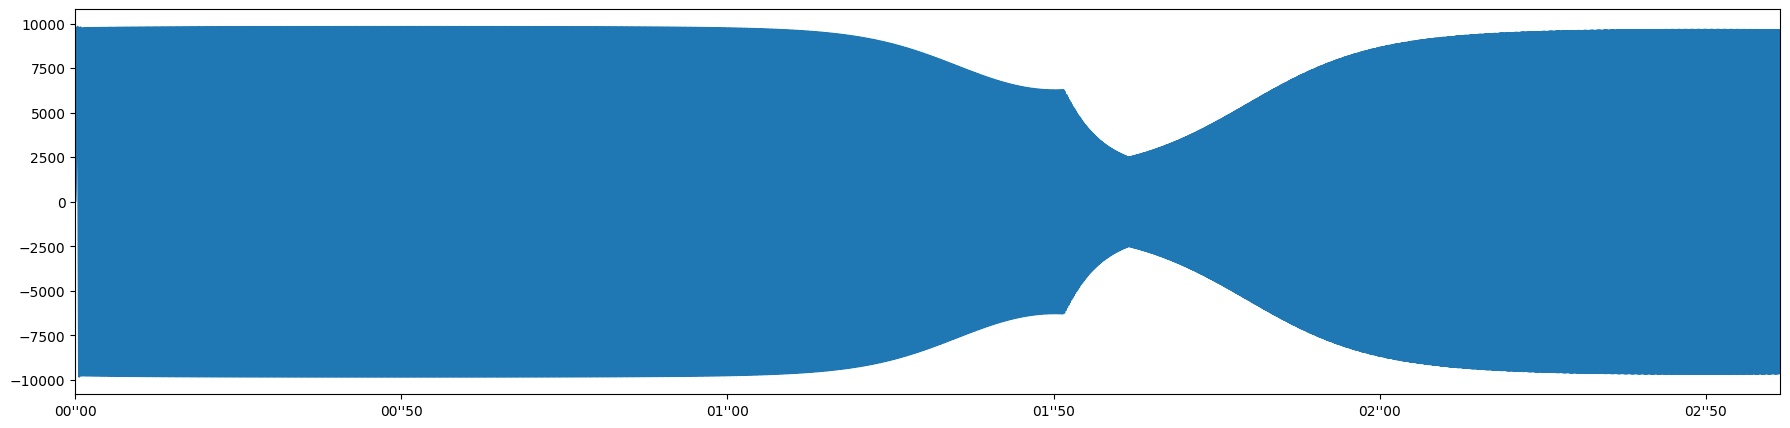

In [4]:
from hum import disp_wf 

disp_wf(wf, sr)

### 🎛️ Example 2: Distortion and Reverb

In [3]:
from hum.pyo_util import example_02_distortion_and_reverb

example_02_distortion_and_reverb()

### 🎛️ Example 3: Detuned Polyphonic Feel

In [ ]:
from hum.pyo_util import example_03_detuned_polyphonic_feel

example_03_detuned_polyphonic_feel()

### 🎛️ Example 4: Dynamic Tremolo and Filter Sweep

In [ ]:
from hum.pyo_util import example_04_dynamic_tremolo_and_filter_sweep

example_04_dynamic_tremolo_and_filter_sweep()

### 🎛️ Example 5: Offline Rendering

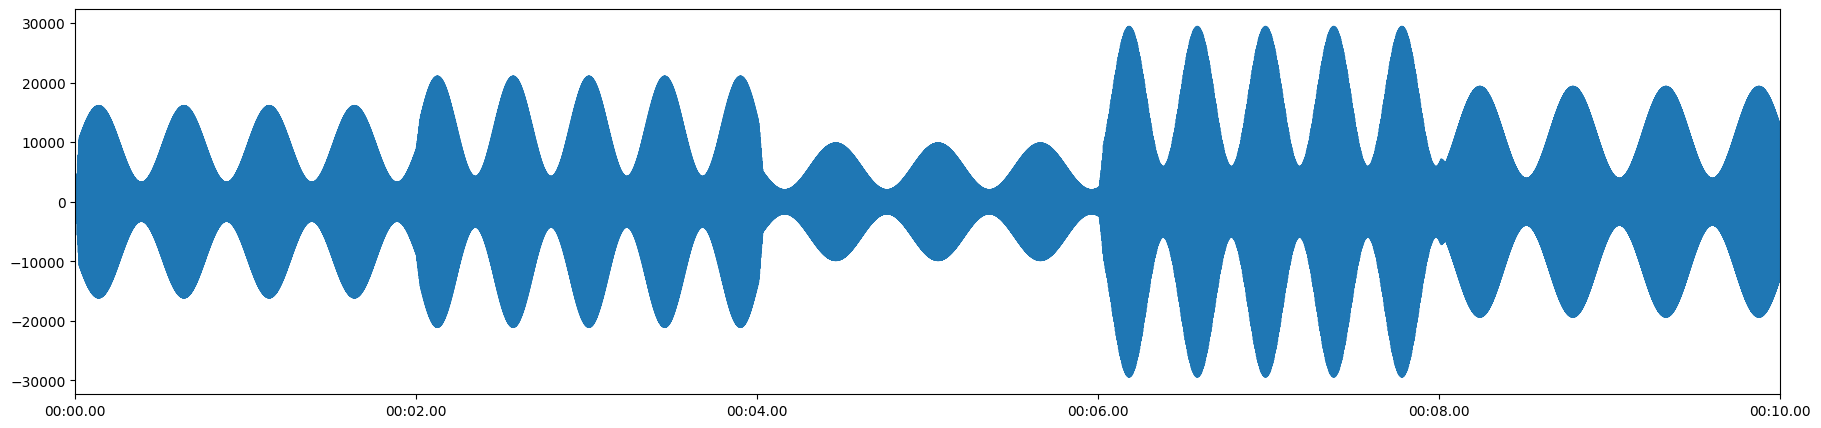

In [ ]:
from hum.pyo_util import example_05_offline_rendering
from hum import disp_wf


wf, sr = example_05_offline_rendering()

disp_wf(wf, sr)

# Scrap

In [ ]:
"""
Refactored Knobs and Synth classes with recording functionality moved from Knobs to Synth.
"""

class Knobs(MutableMapping):
    """
    A simplified class for managing signal parameters (as SigTo).

    Behaves like a MutableMapping (dict-like) for parameter access.
    Recording functionality has been moved to the Synth class.
    """

    def __init__(self, param_dict: KnobsDict):
        """
        Parameters
        ----------
        param_dict : dict
            A dictionary of parameters to be used in the synthesizer.
            The keys are the names of the parameters, and the values are the initial values.
        """
        self._params = param_dict
        self._sig_to_params = {
            k: v for k, v in param_dict.items() if isinstance(v, SigTo)
        }

    def __call__(self, **updates_kwargs):
        """Update parameters using keyword arguments."""
        self.update(updates_kwargs)

    def update(self, updates: KnobsDict = (), /, **kwargs):
        """
        Update the parameters of the synthesizer.

        Parameters
        ----------
        updates : dict
            A dictionary of parameters to update. The keys are the names of the parameters,
            and the values are the new values for those parameters.

        Mostly, the knob updates values are numbers, but you can also express how a
        particular knob should transition to that number ("value") from where it is now,
        by specifying a "time" parameter. The time parameter is the number of seconds
        it takes to transition to the new value.
        You can also specify a "mul" and "add" parameter, which are multiplied and
        added to the value respectively.
        Essentially, you can specify a `pyo.SigTo` object as the value of a knob.
        """
        if isinstance(updates, dict):
            combined = updates.copy()
        elif hasattr(updates, "__iter__"):
            combined = dict(updates)
        else:
            raise TypeError("Knobs.update() requires a mapping or iterable of pairs")

        combined.update(kwargs)
        
        for k, v in combined.items():
            sig = self._params[k]
            if isinstance(sig, SigTo):
                if isinstance(v, dict):
                    # Note: No validation of the v keys. If you pass keys that are not
                    # valid SigTo parameters, (i.e. other than value, time, mul or add)
                    # it will simply add them to the SigTo object as attributes, but
                    # that won't have any (audible) effect.
                    for attr_name, attr_value in v.items():
                        setattr(sig, attr_name, attr_value)
                else:
                    sig.value = v
            else:
                # Not a SigTo: Replace value directly
                self._params[k] = v

    @property
    def __signature__(self):
        return Signature(
            parameters=[
                Parameter(name, kind=Parameter.KEYWORD_ONLY) for name in self._params
            ]
        )

    def __setitem__(self, key, value):
        self.update({key: value})

    def __getitem__(self, key):
        return self._params[key]

    def __delitem__(self, key):
        del self._params[key]

    def __iter__(self):
        return iter(self._params)

    def __len__(self):
        return len(self._params)

    def __repr__(self):
        return f"<Knobs {list(self._params.keys())}>"


class Synth(MutableMapping):
    """
    A class for creating a real-time synthesizer using pyo.

    The synth_func is a function whose arguments determine the parameters of the synthesizer.
    We call a dictionary of such parameters "knobs":
    These are dicts that specify the value for each knob (i.e. sound parameter) that
    has changed (all other sound parameters remain as they were).

    Mostly, the knobs values are numbers, but you can also express how a particular knob
    should transition to that number ("value") from where it is now, by specifying
    a "time" parameter. The time parameter is the number of seconds it takes to
    transition to the new value.
    You can also specify a "mul" and "add" parameter, which are multiplied and added to the value
    respectively.
    Essentially, you can specify a `pyo.SigTo` object as the value of a knob.
    """

    default_time_time = DFLT_TIME_TIME

    def __init__(
        self,
        synth_func,
        *,
        knob_params: Optional[Set[str]] = None,
        knob_exclude: Optional[Set[str]] = None,
        sr=DFLT_PYO_SR,
        nchnls=DFLT_PYO_NCHNLS,
        record_on_start: bool = True,
        event_log_factory: RecordFactory = list,  # No argument factory that makes an Appendable
        audio='portaudio',
        verbosity=DFLT_PYO_VERBOSITY,
        **server_kwargs,
    ):
        """
        Parameters
        ----------
        synth_func : callable
            A function that returns a pyo object. The function should accept keyword arguments
            that are the parameters of the synthesizer.
        knob_params : Optional[Set[str]]
            Parameters to treat as live knobs (controllable in real-time). 
            If None, defaults to all parameters.
        knob_exclude : Optional[Set[str]]
            Parameters to exclude from live knobs.
        sr : int
            The sample rate of the server. Default is 44100.
        nchnls : int
            The number of channels of the server. Default is 1.
        record_on_start : bool
            Whether to start recording when the server starts. Default is True.
        event_log_factory : callable
            A function that returns an empty list or other Appendable object to store the
            recorded events. Default is list.
        audio : str
            The audio driver to use. Default is 'portaudio'.
        verbosity : int
            The verbosity level of the server. Default is 1.
        server_kwargs : dict
            Additional keyword arguments to pass to the pyo Server constructor.
        """
        self._server_kwargs = dict(
            server_kwargs, sr=sr, nchnls=nchnls, verbosity=verbosity, audio=audio
        )
        self._synth_func = synth_func
        self._server = None
        self.output = None
        self._synth_func_params = synth_func_defaults(synth_func)

        _knob_params = knob_params or getattr(
            synth_func, '_knob_params', set(self._synth_func_params)
        )
        _knob_params = list_if_string(_knob_params)
        _knob_exclude = knob_exclude or getattr(synth_func, '_knob_exclude', set())
        knob_exclude = list_if_string(knob_exclude)
        self._knob_params = set(_knob_params) - set(_knob_exclude)
        self._knob_defaults = {k: self._synth_func_params[k] for k in _knob_params}
        self._live_params = set(self._knob_params)
        self._rebuild_params = set(self._synth_func_params) - set(self._knob_params)

        # Recording
        self._record_on_start = record_on_start
        self._event_log_factory = event_log_factory
        self._recording = False
        self._recording_start_time = None
        self._recorded_events = None

        self.knobs = Knobs(self._synth_func_params)

    def __call__(self, **updates):
        """
        Call the synthesizer with the given updates.
        """
        self.update(updates)

    def update(self, updates: KnobsDict):
        """
        Update the synthesizer parameters and record changes if recording is active.

        - Live parameters (SigTo) are updated smoothly.
        - Rebuild parameters (non-SigTo, like n_voices) trigger a full synth rebuild.
        
        This method handles parameter updates and recording in one place, unlike the
        previous design where recording was handled in the Knobs class.
        """
        live_updates = {}
        rebuild_updates = {}

        for k, v in updates.items():
            if k in self._live_params:
                live_updates[k] = v
            elif k in self._rebuild_params:
                rebuild_updates[k] = v
            else:
                raise ValueError(f"Unknown parameter: {k}")

        # Record the update if recording is active
        if self._recording and (live_updates or rebuild_updates):
            self._record_update(updates)

        if live_updates:
            self.knobs.update(live_updates)

        if rebuild_updates:
            self._rebuild_graph(rebuild_updates)

    def _record_update(self, updates: KnobsDict):
        """
        Record parameter updates with timestamps.
        
        Parameters
        ----------
        updates : dict
            Dictionary of parameter updates to record
        """
        if not self._recording_start_time:
            raise RuntimeError("Recording start time not set. Did you call start_recording()?")
            
        rel_time = time.time() - self._recording_start_time
        self._recorded_events.append((rel_time, updates))

    def _rebuild_graph(self, rebuild_updates: KnobsDict):
        """
        Rebuild the synthesizer graph when structural parameters change.
        
        This happens when non-SigTo parameters are updated, requiring a complete
        reconstruction of the synthesis graph.
        """
        # Stop current graph
        if self.output is not None:
            self.output.stop()

        # Merge current parameter values
        merged_params = {}

        # Start from live current knob values
        for k, v in self.knobs.items():
            if isinstance(v, SigTo):
                merged_params[k] = v.value  # unwrap SigTo current value
            else:
                merged_params[k] = v

        # Also update with explicit new rebuild updates
        merged_params.update(rebuild_updates)

        # Store updated synth_func_params
        self._synth_func_params.update(merged_params)

        # Rebuild knobs
        new_initial_knob_params = {}
        for name, spec in merged_params.items():
            if name in self._live_params:
                new_initial_knob_params[name] = dict_to_sigto(spec)
            else:
                new_initial_knob_params[name] = spec

        self.knobs = Knobs(new_initial_knob_params)

        # Rebuild output
        try:
            self.output = self._synth_func(**new_initial_knob_params)
        except TypeError as e:
            raise TypeError(
                f"Failed to rebuild synth function '{self._synth_func.__name__}'.\n"
                f"Original error: {e}"
            ) from e

        self.output.out()
        
        # Record rebuild if recording is active
        if self._recording:
            self._record_update(rebuild_updates)
        
    @property
    def _initial_knob_params(self):
        _initial_knob_params = {}
        for name, spec in self._synth_func_params.items():
            if name in self._knob_params:
                _initial_knob_params[name] = dict_to_sigto(spec)
            else:
                _initial_knob_params[name] = spec

        return _initial_knob_params

    def _init_recorded_events(self):
        """Initialize the recording structure."""
        self._recorded_events = self._event_log_factory()
        # The first event should be the initial state of the synth_func
        self._recorded_events.append((0, serialize_knobs(self.knobs)))

    def start_recording(self):
        """
        Start recording parameter updates.
        
        Records the initial state of all knobs and prepares to record future updates.
        """
        if self.knobs is None:
            raise RuntimeError(
                "Cannot start recording without initializing knobs. "
                "Did you forget to call start() or do a with synth... block?"
            )
            
        self._recording = True
        self._recorded_events = self._event_log_factory()
        self._recording_start_time = time.time()
        
        # Record initial state of all knobs
        initial_state = serialize_knobs(self.knobs)
        self._recorded_events.append((0, initial_state))

    def stop_recording(self):
        """
        Stop recording parameter updates.
        
        Adds a final empty event with the current timestamp to mark the end of recording.
        """
        if not self._recording:
            return
            
        self._recording = False

        # Inject a final dummy event at current relative time
        if self._recorded_events and self._recording_start_time is not None:
            now = time.time()
            rel_now = now - self._recording_start_time
            self._recorded_events.append((rel_now, {}))

    def get_recording(self, process_recording: Callable = _json_friendly_records):
        """Get the recorded parameter updates."""
        return process_recording(self._recorded_events)

    def get_update_log(self):
        """
        Get the recorded parameter updates.
        
        Returns a list of updates without timestamps (unlike get_recording).
        If nothing has been recorded, returns an empty list.
        """
        if not self._recorded_events:
            return []
            
        # Extract just the update dictionaries, ignoring timestamps
        return [updates for _, updates in self._recorded_events if updates]

    def start(self):
        """
        Start the synthesizer.
        
        This boots the server, initializes knobs, starts the audio output,
        and optionally begins recording.
        """
        if self._server is None:
            self._server = Server(**self._server_kwargs).boot()

        _initial_knob_params = self._initial_knob_params.copy()

        self.knobs = Knobs(_initial_knob_params)

        try:
            self.output = self._synth_func(**_initial_knob_params)
        except TypeError as e:
            raise TypeError(
                f"Failed to initialize synth function '{self._synth_func.__name__}'.\n"
                f"Perhaps some arguments were wrongly wrapped into SigTo.\n"
                f"Consider :\n"
                f"  * using the sigto_include argument to control which parameters are live.\n"
                f"  * using the sigto_exclude argument to control which parameters are not live.\n"
                f"Alternatively, at function definition time, you can control this by:\n"
                f"  * using the @knob_params decorator to control which parameters are live.\n"
                f"  * using the @knob_exclude decorator to control which parameters are not live.\n"
                f"Original error: {e}"
            ) from e

        self.output.out()

        self._server.start()

        if self._record_on_start:
            self.start_recording()

    def stop(self):
        if self.output is not None:
            self.output.stop()
        if self._server is not None:
            self._server.stop()
        if self._record_on_start:
            self.stop_recording()

    def play_events(
        self,
        events: Iterator[Union[KnobsDict, None]],
        *,
        idle_sleep_time=0.01,
        inter_event_delay=0,
        tail_time=1.0,
    ):
        """
        Play an event stream, applying updates from an iterator of KnobsDicts or None.

        Parameters
        ----------
        events : Iterator[Union[KnobsDict, None]]
            An iterator yielding KnobsDict updates (or None for idle).
        tail_time : float
            Time to wait after finishing event playback to allow sound to finish.
        idle_sleep_time : float
            Time to sleep if the iterator yields None (idle).
        inter_event_delay : float
            Time to sleep systematically after each non-None event.
        """
        with self:
            for event in events:
                if event is None:
                    time.sleep(idle_sleep_time)
                    continue

                self.update(event)

                if inter_event_delay > 0:
                    time.sleep(inter_event_delay)

            time.sleep(tail_time)

    def replay_events(self, control_events, *, tail_time=1.0):
        self.play_events(ReplayEvents(control_events), tail_time=tail_time)

    def render_recording(
        self,
        control_events=None,
        *,
        output_filepath=None,
        egress=lambda x: x,
        file_format='wav',
    ):
        """Render the recording to a file or return it processed by the egress function."""
        if not control_events:
            control_events = self.get_recording()
            if not control_events:
                raise ValueError("Nothing to render. No control events recorded.")

        TIME_IDX = 0
        base_time = control_events[0][TIME_IDX]
        normalized = [(t - base_time, knobs) for t, knobs in control_events]
        total_duration = normalized[-1][TIME_IDX] + 0.1  # add small buffer

        offline_server_kwargs = dict(self._server_kwargs, audio="offline")
        server = Server(**offline_server_kwargs).boot()
        table = NewTable(length=total_duration)

        all_keys = set(k for _, knobs in control_events for k in knobs)
        raw_params = {k: SigTo(value=0, time=0.01) for k in all_keys}
        synth_output = self._synth_func(**raw_params).out()
        table_recorder = TableRec(synth_output, table=table).play()

        try:
            for i, (event_time, updates) in enumerate(normalized):
                next_time = (
                    normalized[i + 1][TIME_IDX]
                    if i + 1 < len(normalized)
                    else total_duration
                )
                dur = next_time - event_time

                for key, val in updates.items():
                    if isinstance(val, dict):
                        for attr in ['value', 'time', 'mul', 'add']:
                            if attr in val:
                                setattr(raw_params[key], attr, val[attr])
                    else:
                        raw_params[key].value = val

                server.recordOptions(dur=dur)
                server.start()
        finally:
            table_recorder.stop()

        if output_filepath is None:
            tmpfile = tempfile.NamedTemporaryFile(
                suffix=f".{file_format}", delete=False
            )
            output_filepath = tmpfile.name
            tmpfile.close()

        table.save(output_filepath)

        if egress is None:
            return output_filepath
        elif callable(egress):
            with open(output_filepath, "rb") as f:
                audio = f.read()
            return egress(audio)
        else:
            raise ValueError("Invalid egress")

    def __del__(self):
        if self._server is not None:
            self._server.stop()

    def __enter__(self):
        self.start()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.stop()

    @property
    def __signature__(self):
        return Signature(
            parameters=[
                Parameter(name, kind=Parameter.KEYWORD_ONLY) for name in self.knobs
            ]
        )

    def __setitem__(self, key, value):
        self.update({key: value})

    def __getitem__(self, key):
        return self.knobs[key]

    def __delitem__(self, key):
        del self.knobs[key]

    def __iter__(self):
        return iter(self.knobs)

    def __len__(self):
        return len(self.knobs)

    def __repr__(self):
        return f"<Synth {list(self.knobs.keys())}>"

In [2]:
from hum.pyo_util import example_01_basic_dual_osc
from hum import disp_wf 

wf, sr = example_01_basic_dual_osc()

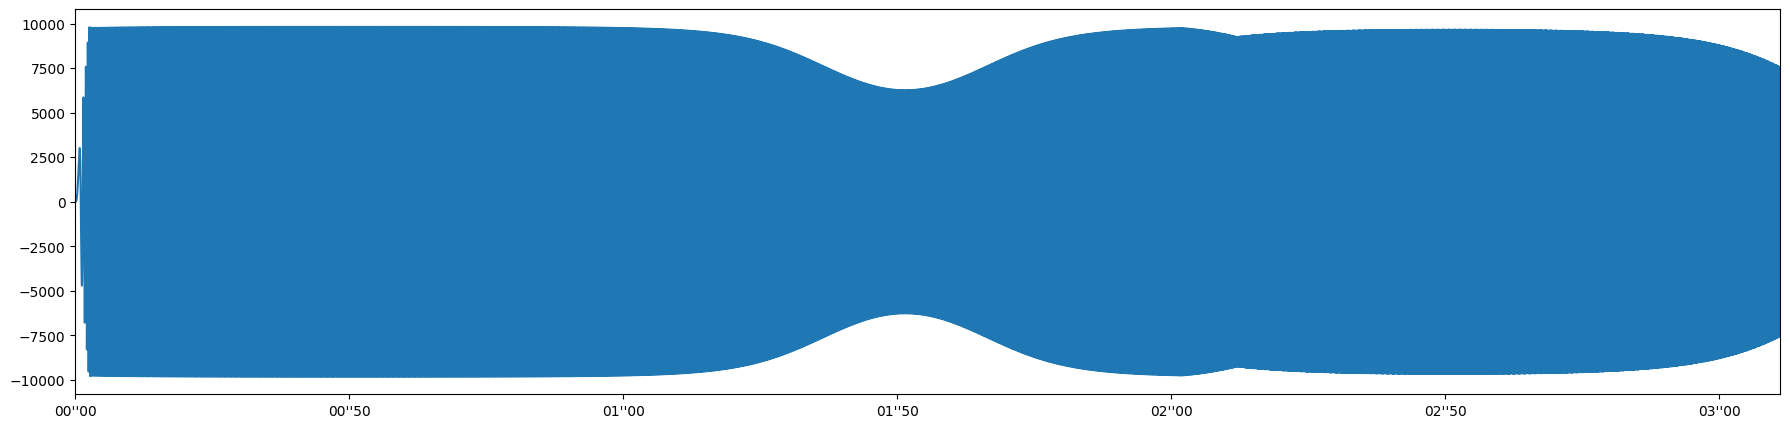

In [1]:
from hum.pyo_util import example_06_knob_recording_playback
from hum import disp_wf 

wf, sr = example_06_knob_recording_playback()

disp_wf(wf, sr)


In [2]:
records = [
    (
        0.0,
        {
            'freq1': {'value': 220, 'time': 0.025, 'mul': 1, 'add': 0},
            'freq2': {'value': 330, 'time': 0.025, 'mul': 1, 'add': 0},
            'amp': {'value': 0.3, 'time': 0.025, 'mul': 1, 'add': 0},
            'lfo_freq': {'value': 0.5, 'time': 0.025, 'mul': 1, 'add': 0},
        },
    ),
    (0.06312704086303711, {'freq1': 440}),
    (1.0686028003692627, {'freq2': {'value': 550, 'time': 0.5, 'mul': 1, 'add': 0}}),
    (2.074380874633789, {'freq1': {'value': 880, 'time': 0.1}, 'freq2': 1100}),
    (3.0789618492126465, {}),
]

("recorded_frames=[(0.0, {'freq1': {'value': 220, 'time': 0.025, 'mul': 1, "
 "'add': 0}, 'freq2': {'value': 330, 'time': 0.025, 'mul': 1, 'add': 0}, "
 "'amp': {'value': 0.3, 'time': 0.025, 'mul': 1, 'add': 0}, 'lfo_freq': "
 "{'value': 0.5, 'time': 0.025, 'mul': 1, 'add': 0}}), (7.295608520507812e-05, "
 "{'freq1': 440}), (1.0036530494689941, {'freq2': {'value': 550, 'time': 0.5, "
 "'mul': 1, 'add': 0}}), (2.01123309135437, {'freq1': {'value': 880, 'time': "
 "0.1}, 'freq2': 1100}), (3.0143749713897705, {})]")


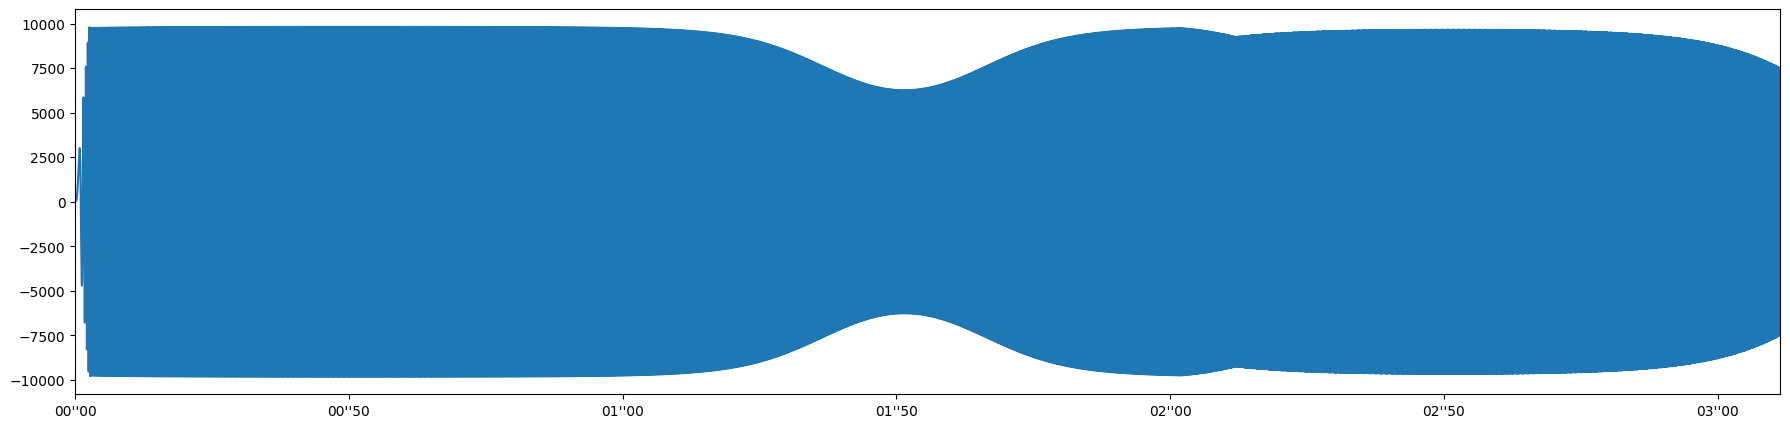

In [1]:
from hum import Synth, disp_wf
import time
from pyo import Sine, ButLP, SigTo, Mix


# Dual sine oscillator with LFO-controlled lowpass filter
def dual_osc_graph(freq1=220, freq2=330, amp=0.3, lfo_freq=0.5):
    osc1 = Sine(freq=freq1)
    osc2 = Sine(freq=freq2)
    blend = Mix([osc1, osc2], voices=2) * amp
    lfo = Sine(freq=lfo_freq).range(400, 2000)
    return ButLP(blend, freq=lfo)

synth = Synth(dual_osc_graph)

with synth:
    synth.knobs['freq1'] = 440
    time.sleep(1)
    synth.knobs['freq2'] = SigTo(550, time=0.5)  # Smooth shift
    time.sleep(1)
    synth.knobs.update(dict(freq1={'value': 880, 'time': 0.1}, freq2=1100))
    time.sleep(1)

recorded_frames = synth.get_recording()
from pprint import pprint
pprint(f"{recorded_frames=}")
assert len(recorded_frames) > 0, "No frames recorded"

wav_bytes = synth.render_recording(recorded_frames)

disp_wf(wav_bytes)

In [2]:
recorded_frames

[(0.0,
  {'freq1': {'value': 220, 'time': 0.025, 'mul': 1, 'add': 0},
   'freq2': {'value': 330, 'time': 0.025, 'mul': 1, 'add': 0},
   'amp': {'value': 0.3, 'time': 0.025, 'mul': 1, 'add': 0},
   'lfo_freq': {'value': 0.5, 'time': 0.025, 'mul': 1, 'add': 0}}),
 (7.295608520507812e-05, {'freq1': 440}),
 (1.0036530494689941,
  {'freq2': {'value': 550, 'time': 0.5, 'mul': 1, 'add': 0}}),
 (2.01123309135437, {'freq1': {'value': 880, 'time': 0.1}, 'freq2': 1100}),
 (3.0143749713897705, {})]

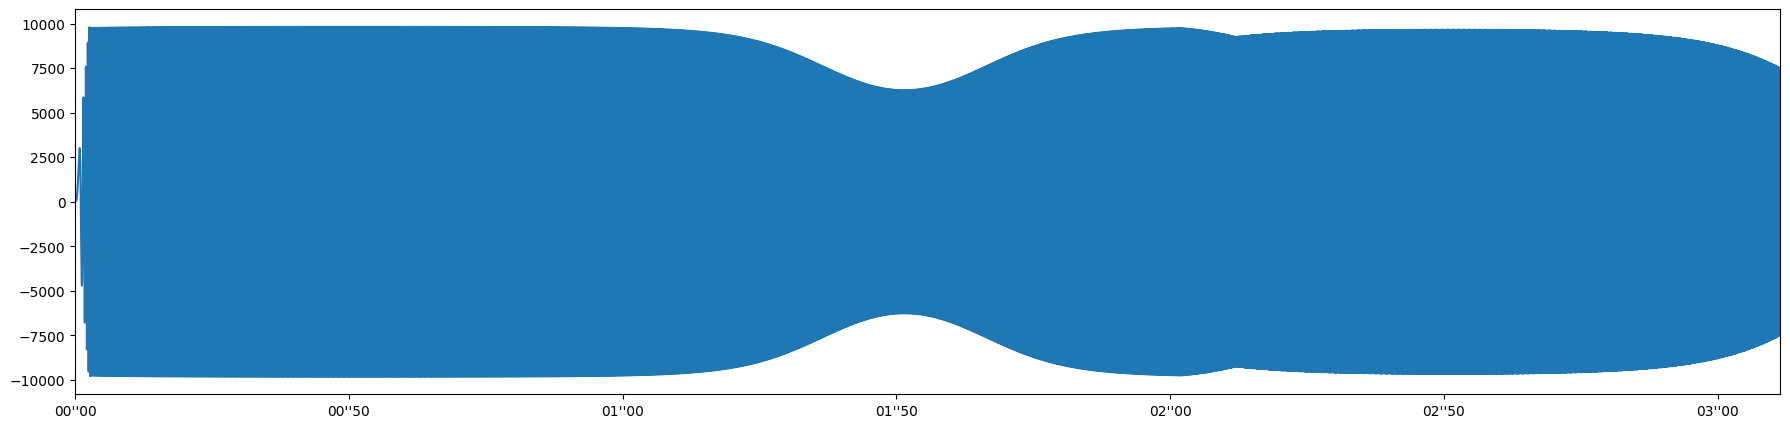

In [3]:
def dual_osc_graph(freq1=220, freq2=330, amp=0.3, lfo_freq=0.5):
    osc1 = Sine(freq=freq1)
    osc2 = Sine(freq=freq2)
    blend = Mix([osc1, osc2], voices=2) * amp
    lfo = Sine(freq=lfo_freq).range(400, 2000)
    return ButLP(blend, freq=lfo)

synth = Synth(dual_osc_graph)

wav_bytes = synth.render_recording(recorded_frames)

disp_wf(wav_bytes)

In [ ]:
synth.knobs['freq1'] = {'value': 440}
time.sleep(1)
synth.knobs['freq2'] = {'value': 550, 'time': 0.5}

In [16]:
import recode 

recode.decode_wav_header_bytes(wav_bytes)

{'sr': 44100,
 'width_bytes': 2,
 'n_channels': 1,
 'nframes': 137005,
 'comptype': None}

In [5]:
synth = Synth(dual_osc_graph)
list(synth.knobs)

['freq1', 'freq2', 'amp', 'lfo_freq']

In [6]:
synth.knobs['freq1'] = 440

In [8]:
synth.knobs['freq2'] *= 2

In [9]:
synth.knobs._update_log

[{'freq1': 440}, {'freq2': 660}]

In [10]:
synth.knobs(freq1=100)

In [11]:
synth.knobs._update_log

[{'freq1': 440}, {'freq2': 660}, {'freq1': 100}]

In [3]:
from hum import Synth, disp_wf
import time
from pyo import Sine, ButLP, SigTo, Mix

# Dual sine oscillator with LFO-controlled lowpass filter
def dual_osc_graph(freq1=220, freq2=330, amp=0.3, lfo_freq=0.5):
    osc1 = Sine(freq=freq1)
    osc2 = Sine(freq=freq2)
    blend = Mix([osc1, osc2], voices=2) * amp
    lfo = Sine(freq=lfo_freq).range(400, 2000)
    return ButLP(blend, freq=lfo)


synth = Synth(dual_osc_graph)


In [9]:
from inspect import signature

with synth:
    print(signature(synth.knobs))
    print(list(synth.knobs))

(*, freq1, freq2, amp, lfo_freq)
['freq1', 'freq2', 'amp', 'lfo_freq']


In [ ]:
with synth:
    time.sleep(0.1)
    synth.knobs

{'freq1': 220, 'freq2': 330, 'amp': 0.3, 'lfo_freq': 0.5}

In [3]:
s = records[1][1]['freq2']
dir(s)


['add', 'mul', 'time', 'value']

NameError: name 's' is not defined